# Optimising Parameters of the mini CNN

In this script, we iterate through different parameters of your choosing and output the f1 metric for each. \
Used to find which parameters result in the best F1 metric

## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score,f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D,MaxPool2D, InputLayer, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
import keras
import tensorflow as tf

import pickle

from tensorflow.keras import backend as K

## Load data and split data

In [73]:
output_prefix = "model_complex.keras"

# Previously stored data
with open('all_data.pkl', 'rb') as f:
    images, labels = pickle.load(f)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.4, random_state=42)

## Custom F1 score metric
By Prof Andrew

In [2]:
@keras.saving.register_keras_serializable()
def f1_metric(y_true, y_pred):
    y_true = K.cast(y_true, 'int32')
    y_pred = K.cast(K.round(y_pred), 'int32')
    TP = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    TN = K.sum(K.cast((1 - y_true) * (1 - y_pred), 'float'), axis=0)
    FP = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    FN = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    precision = TP / (TP + FP + K.epsilon())
    recall = TP / (TP + FN + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

## Define Neural Network
- Used to print structure and see how many parameters are used
- Aim for <1k for use in embedded environment

In [13]:
model = Sequential()
    
model.add(InputLayer(shape=(images.shape[1], images.shape[2], 1)))
model.add(Conv2D(8, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(4, 4))) # max pool helps to keep number of params down

model.add(Flatten())

model.add(Dense(11, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(7, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(11, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))
model.add(Dropout(0.3))

# print out the model structure/summary
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 10, 12, 8)           │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 2, 3, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 48)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 11)                  │             539 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 11)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 7)                   │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 7)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 11)                  │              88 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 11)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 2)                   │              24 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 815 (3.18 KB)

 Trainable params: 815 (3.18 KB)

 Non-trainable params: 0 (0.00 B)

## Define neural network 2
- Used to define the structure of a new neural network where we ignore hardware constraints
- Used to explore the idea of having more complex hardware and if it allows for a better model

In [122]:
model = Sequential()
    
model.add(InputLayer(shape=(images.shape[1], images.shape[2], 1)))
model.add(Conv2D(8, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(3, 3))) # max pool helps to keep number of params down

model.add(Flatten())

model.add(Dense(12, activation='relu'))
#model.add(Dropout(0.5))

model.add(Dense(12, activation='relu'))
#model.add(Dropout(0.5))

model.add(Dense(12, activation='relu'))
#model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))
#model.add(Dropout(0.5))

# print out the model structure/summary
model.summary()

Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_51 (Conv2D)                   │ (None, 10, 12, 8)           │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_49 (MaxPooling2D)      │ (None, 3, 4, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_51 (Flatten)                 │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_204 (Dense)                    │ (None, 12)                  │           1,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_205 (Dense)                    │ (None, 12)                  │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_206 (Dense)                    │ (None, 12)                  │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_207 (Dense)                    │ (None, 2)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,582 (6.18 KB)

 Trainable params: 1,582 (6.18 KB)

 Non-trainable params: 0 (0.00 B)

## Iterating through different parameters
Going through each parameter, creating a new CNN, training and testing

In [123]:
for param in [None]:

    '''
    # Step 4: Build the CNN followed by dense neural network
    model = Sequential()
    
    model.add(InputLayer(shape=(images.shape[1], images.shape[2], 1)))
    model.add(Conv2D(8, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(4, 4))) # max pool helps to keep number of params down
    
    model.add(Flatten())
    
    model.add(Dense(11, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(7, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(11, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(2, activation='softmax'))
    model.add(Dropout(0.3))
    
    # print out the model structure/summary
    #model.summary()
    '''
    
    #optimizer = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1_metric]) # use this for f1 as loss
    #model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision()]) # use this for accuracy as loss
    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

    # Step 5: Evaluate and plot the confusion matrix
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    # Step 7: Calculate and print the F1 score
    f1 = f1_score(y_test_labels, y_pred)
    print(f"Param: {param} | F1 Score: {f1:.2f}")

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - f1_metric: 0.3913 - loss: 0.6686 - val_f1_metric: 0.5176 - val_loss: 0.6171
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - f1_metric: 0.5589 - loss: 0.5821 - val_f1_metric: 0.8165 - val_loss: 0.5098
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - f1_metric: 0.8218 - loss: 0.4531 - val_f1_metric: 0.8645 - val_loss: 0.3407
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_metric: 0.8640 - loss: 0.3152 - val_f1_metric: 0.8616 - val_loss: 0.2800
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_metric: 0.8870 - loss: 0.2435 - val_f1_metric: 0.9054 - val_loss: 0.1984
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - f1_metric: 0.9055 - loss: 0.2147 - val_f1_metric: 0.8888 - val_loss: 0.1996
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - f1_metric: 0.9216 - loss: 0.1913 - val_f1_metric: 0.9189 - val_loss: 0.1763
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_metric: 0.9380 - loss: 0.1663 - val_f1_m

## Print confusion matrix

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


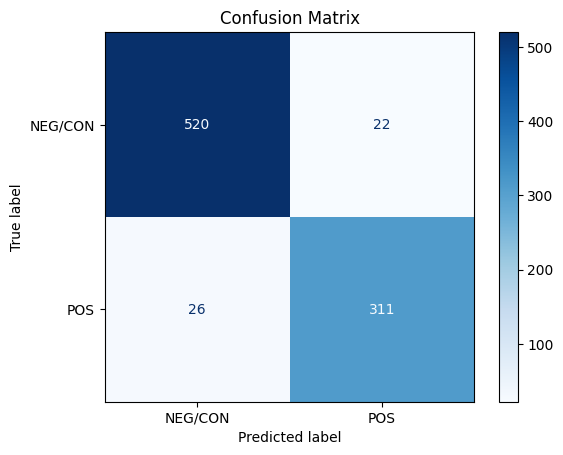

In [124]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NEG/CON", "POS"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## ROC Curve
Plots points for 0.5 and 0.9 threshold \
Also prints the f1 score using the custom function

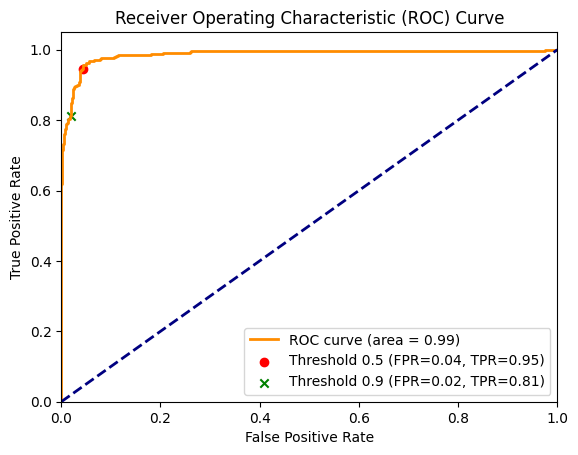

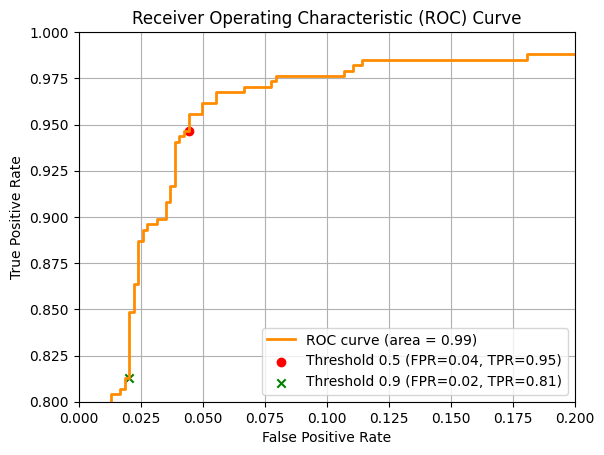

F1 Score: 0.94


In [71]:
# Step 6: Calculate and plot the ROC curve
y_prob = y_pred_prob[:, 1]  # Probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test_labels, y_prob)
roc_auc = roc_auc_score(y_test_labels, y_prob)

# Find the point on the ROC curve for the threshold of 0.5
threshold = 0.5
threshold_index = np.argmin(np.abs(thresholds - threshold))
fpr_05 = fpr[threshold_index]
tpr_05 = tpr[threshold_index]


# Find the point on the ROC curve for the threshold of 0.5
threshold = 0.9
threshold_index = np.argmin(np.abs(thresholds - threshold))
fpr_09 = fpr[threshold_index]
tpr_09 = tpr[threshold_index]

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr_05, tpr_05, color='red', marker='o', label=f'Threshold 0.5 (FPR={fpr_05:.2f}, TPR={tpr_05:.2f})')
plt.scatter(fpr_09, tpr_09, color='green', marker='x', label=f'Threshold 0.9 (FPR={fpr_09:.2f}, TPR={tpr_09:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr_05, tpr_05, color='red', marker='o', label=f'Threshold 0.5 (FPR={fpr_05:.2f}, TPR={tpr_05:.2f})')
plt.scatter(fpr_09, tpr_09, color='green', marker='x', label=f'Threshold 0.9 (FPR={fpr_09:.2f}, TPR={tpr_09:.2f})')
plt.xlim([0.0, 0.2])
plt.ylim([0.8, 1.00])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Step 7: Calculate and print the F1 score
f1 = f1_score(y_test_labels, y_pred)
print(f"F1 Score: {f1:.2f}")

## Save model

In [121]:
# Save model
model.save(output_prefix)